# Visualize Experiment Results
This notebook demonstrates how to use the `ResultHandler` to load experiment results.

In [1]:
import os
from pathlib import Path

project_root = Path.cwd().parent
if Path.cwd() != project_root:
    os.chdir(project_root)

from src.utils.resultHandler import ResultHandler
import matplotlib.pyplot as plt
from src.utils.configHandler import ConfigHandler

plt.style.use(os.path.join(os.getcwd(), "configs", "visualisations.mplstyle"))

_config_handler = ConfigHandler()
rh = ResultHandler(_config_handler.SUMMARY_FILE)

folders = rh.get_result_folders()
rh.logger.info(f"Found {len(folders)} result folders.")
folders[:5]

2025-07-23 17:16:08,944 - INFO - src.utils.configHandler - Initializing ConfigHandler with paths_yaml_path: configs/paths.yaml
2025-07-23 17:16:08,945 - INFO - src.utils.configHandler - Successfully loaded paths configuration from YAML file
2025-07-23 17:16:08,948 - INFO - src.utils.resultHandler - Initialized ResultHandler with summary_csv_path: results/summary.csv
2025-07-23 17:16:08,949 - INFO - src.utils.resultHandler - Found 774 result folders.


['results/2025-07-23_16-34-56',
 'results/2025-07-23_16-34-56',
 'results/2025-07-23_16-34-56',
 'results/2025-07-23_16-34-57',
 'results/2025-07-23_16-34-57']

In [2]:
# Filter results for label flipping strategy with random mode
selected_strategy = "label_flipping"
selected_mode = "random"
strategy_params_compare = "flip_ratio"

In [3]:
selected_strategy = "number_instances"
selected_mode = "random"
strategy_params_compare = "reduction_ratio"

In [11]:
selected_strategy = "feature_quality"
selected_mode = "normal"
strategy_params_compare = "noise_level"

In [12]:
import pandas as pd
from ipywidgets import interact, FloatSlider, Dropdown, Checkbox, fixed

strategy_figure_path = os.path.join(os.getcwd(), "figures", selected_strategy)
os.makedirs(strategy_figure_path, exist_ok=True)

subset_results = rh.summary_df[
    (rh.summary_df["strategy"] == selected_strategy)
    & (rh.summary_df["strategy_mode"] == selected_mode)
]
subset_results = subset_results.sort_values(
    by=["dataset", "classifier", "strategy", "strategy_mode", "strategy_params"]
)

# Expand the strategy_params column to separate columns
subset_results["strategy_params"] = subset_results[
    "strategy_params"
].apply(eval)
strategy_params_expanded = subset_results["strategy_params"].apply(
    pd.Series
)
subset_results = pd.concat(
    [subset_results, strategy_params_expanded], axis=1
)

# Create checkboxes for each dataset
dataset_names = subset_results["dataset"].unique()
dataset_checkboxes = {
    name: Checkbox(value=True, description=name) for name in dataset_names
}

In [13]:
def plot_accuracy_vs_strategy_param(subset_results, strategy_params_compare,
    classifier, prepare_save_plot: bool = False, **datasets_selected
):
    fig, ax = plt.subplots()
    flip_ratios = sorted(subset_results[strategy_params_compare].unique())

    for dataset in dataset_names:
        if not datasets_selected.get(dataset, True):
            continue
        ds = subset_results[
            (subset_results["dataset"] == dataset)
            & (subset_results["classifier"] == classifier)
        ]
        if ds.empty:
            continue

        means, stds, valid_strategy_params = [], [], []
        for sp in flip_ratios:
            sp_ds = ds[ds[strategy_params_compare] == sp]
            if sp_ds.empty:
                continue
            grouped = sp_ds.groupby("random_seed")["accuracy"].mean()
            means.append(grouped.mean())
            stds.append(grouped.std())
            valid_strategy_params.append(sp)

        if valid_strategy_params:
            ax.errorbar(
                valid_strategy_params,
                means,
                yerr=stds,
                fmt="-o",
                label=dataset,
                capsize=4,
                markersize=6,
            )

    ax.set_xlabel(f"{strategy_params_compare.capitalize()}")
    ax.set_ylabel(f"{classifier} Accuracy")
    ax.set_title(f"{classifier} Accuracy vs. {strategy_params_compare.capitalize()}")
    ax.set_xlim(min(flip_ratios), max(flip_ratios))
    ax.set_ylim(0, 1)
    ax.legend()
    plt.show()

    if prepare_save_plot:
        return fig


_ = interact(
    plot_accuracy_vs_strategy_param,
    classifier=Dropdown(
        options=subset_results["classifier"].unique(),
        description="Classifier",
    ),
    prepare_save_plot=fixed(False),
    subset_results=fixed(subset_results),
    strategy_params_compare=fixed(strategy_params_compare),
    **dataset_checkboxes,
)

interactive(children=(Dropdown(description='Classifier', options=('catch22', 'mini-rocket'), value='catch22'),…

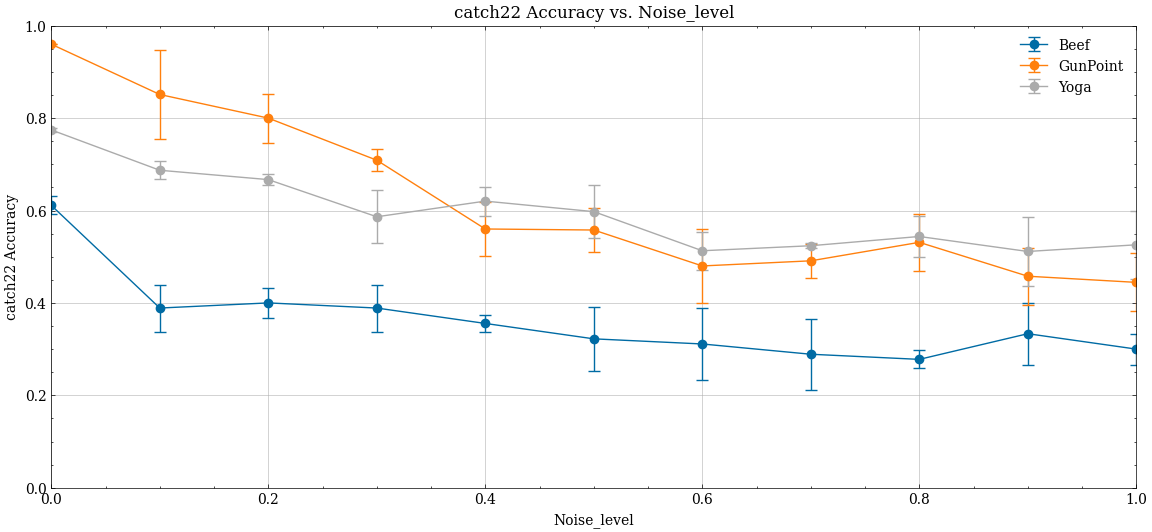

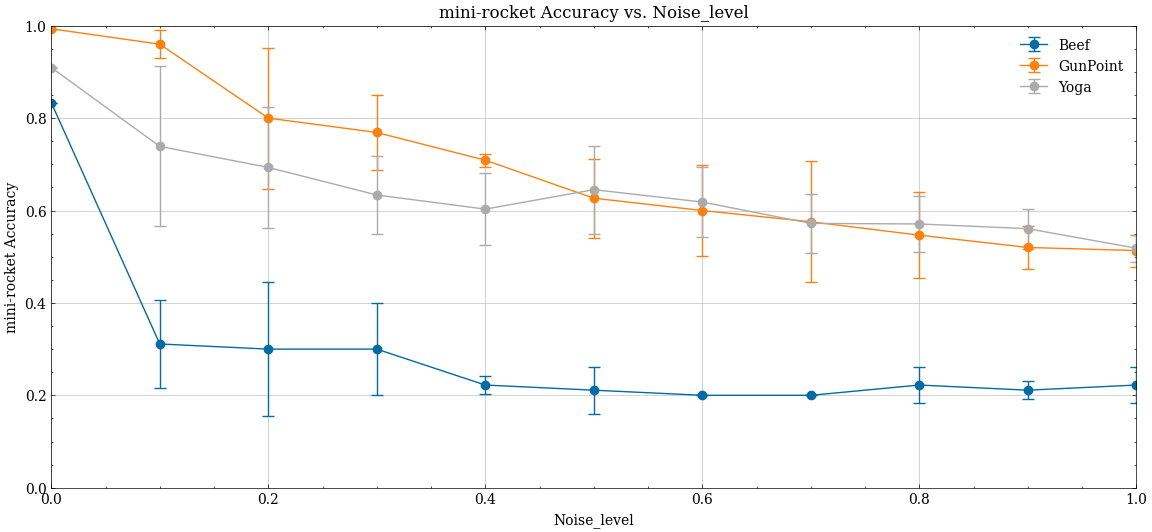

In [14]:
for classifier in subset_results["classifier"].unique():
    fig = plot_accuracy_vs_strategy_param(
        subset_results,
        strategy_params_compare=strategy_params_compare,
        classifier=classifier,
        prepare_save_plot=True,
        **{name: dataset_checkboxes[name].value for name in dataset_names}
    )

    fig.savefig(
        os.path.join(strategy_figure_path, f"accuracy_{classifier}.pdf"),
        dpi=300,
    )
    plt.close(fig)

In [15]:
def plot_accuracy_comparison(
    subset_results,
    strategy_params_compare,
    strategy_params_value,
    classifier1,
    classifier2,
    prepare_save_plot: bool = False,
    **datasets_selected,
):

    subset = subset_results[
        subset_results[strategy_params_compare] == strategy_params_value
    ]
    if subset.empty:
        print(f"No results found for {strategy_params_compare} {strategy_params_value}.")
        return

    subset = subset[subset["classifier"].isin([classifier1, classifier2])]
    if subset.empty or not all(
        c in subset["classifier"].values for c in [classifier1, classifier2]
    ):
        print(
            f"Not enough results for classifiers {classifier1} and {classifier2} at {strategy_params_compare} {strategy_params_value}."
        )
        return

    fig, ax = plt.subplots(figsize=(6, 6))

    for dataset in subset["dataset"].unique():
        if not datasets_selected.get(dataset, True):
            continue
        ds = subset[subset["dataset"] == dataset]
        if ds.empty:
            continue

        grouped = ds.groupby(["random_seed", "classifier"])["accuracy"].mean().unstack()
        if classifier1 not in grouped or classifier2 not in grouped:
            continue
        x = grouped[classifier1]
        y = grouped[classifier2]

        if len(grouped) > 1:
            plt.errorbar(
                x.mean(),
                y.mean(),
                xerr=x.std(),
                yerr=y.std(),
                fmt="o",
                label=dataset,
                capsize=5,
                markersize=8,
            )
        else:
            ax.scatter(x, y, label=dataset, s=50)

    ax.set_xlabel(classifier1 + " Accuracy")
    ax.set_ylabel(classifier2 + " Accuracy")
    ax.set_title(f"Accuracy Comparison at {strategy_params_compare}: {strategy_params_value}")
    ax.axline((0, 0), slope=1, color="grey", linestyle="--")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend()
    plt.show()

    if prepare_save_plot:
        return fig


_ = interact(
    plot_accuracy_comparison,
    strategy_params_compare=fixed(strategy_params_compare),
    strategy_params_value=FloatSlider(
        value=0.1,
        min=float(subset_results[strategy_params_compare].min()),
        max=float(subset_results[strategy_params_compare].max()),
        step=0.1,
        description="Strategy Parameter Value",
    ),
    classifier1=Dropdown(
        options=subset_results["classifier"].unique(),
        description="Classifier 1",
    ),
    classifier2=Dropdown(
        options=subset_results["classifier"].unique(),
        description="Classifier 2",
    ),
    prepare_save_plot=fixed(False),
    subset_results=fixed(subset_results),
    **dataset_checkboxes,
)

interactive(children=(FloatSlider(value=0.1, description='Strategy Parameter Value', max=1.0), Dropdown(descri…

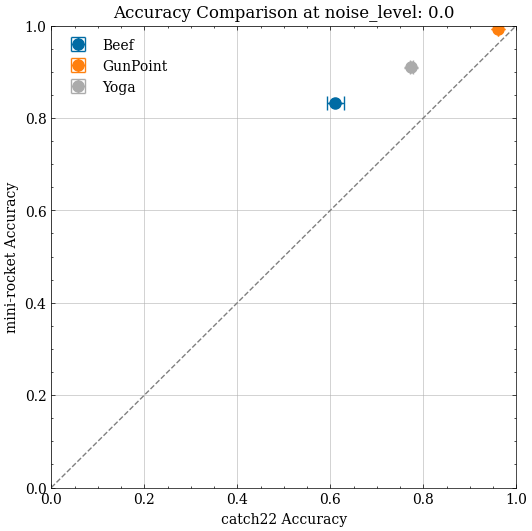

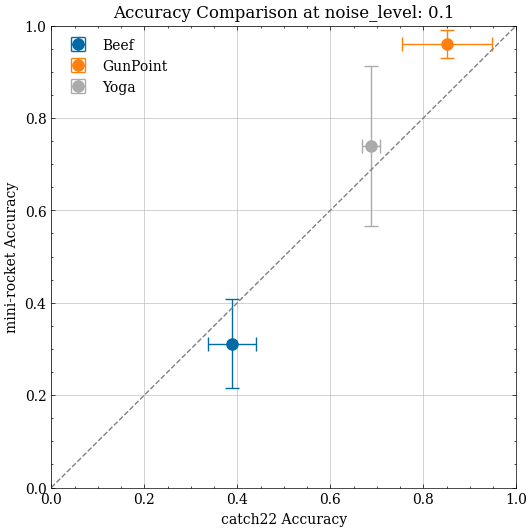

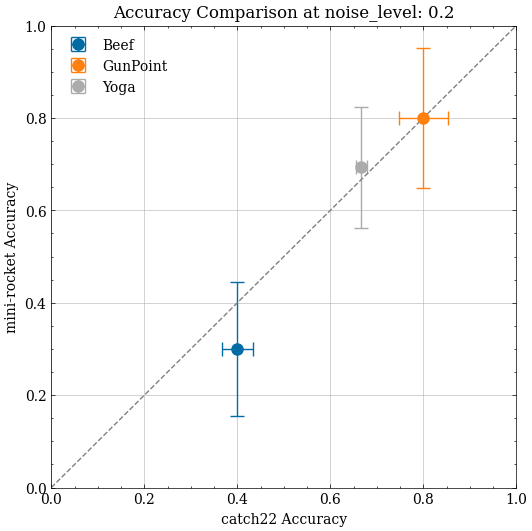

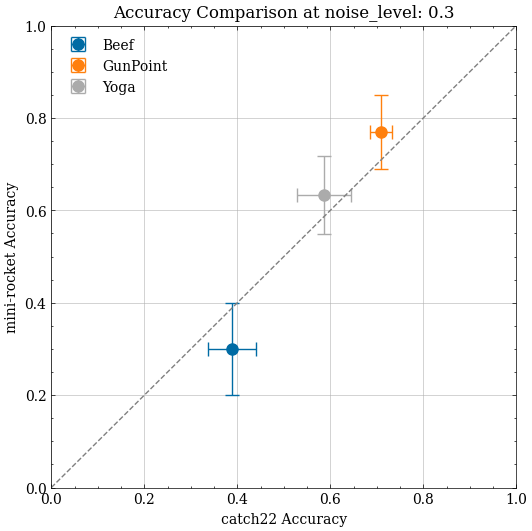

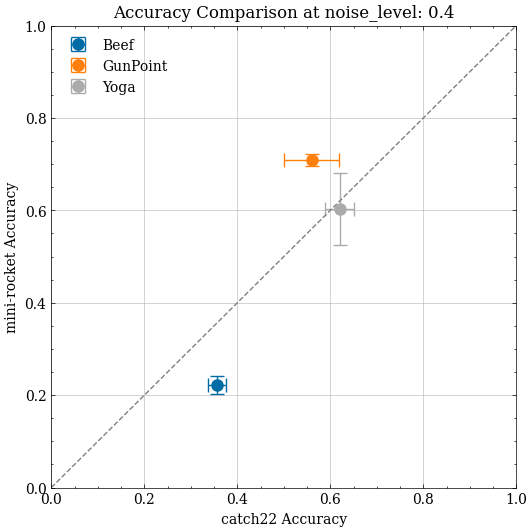

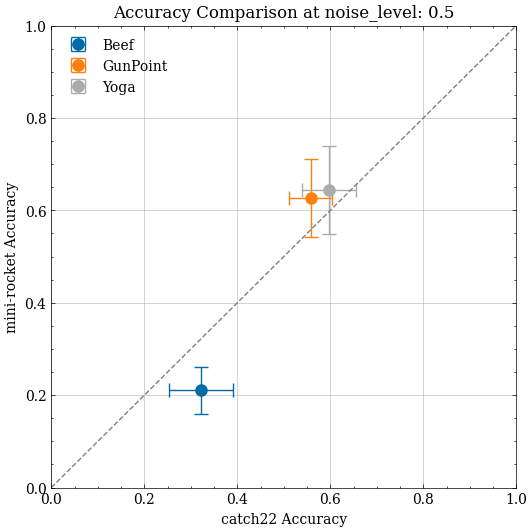

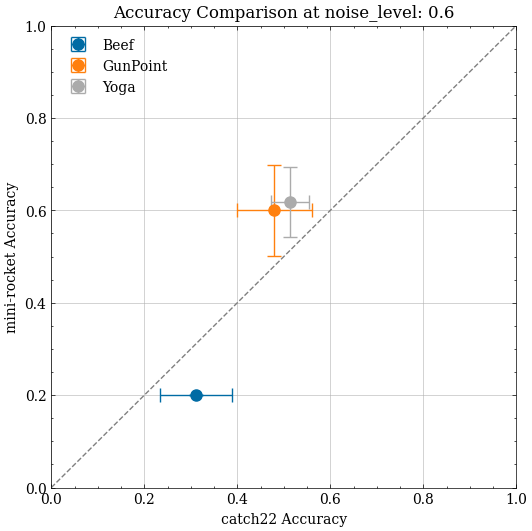

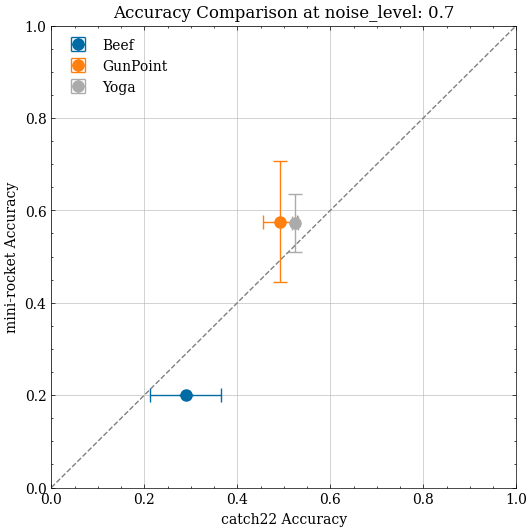

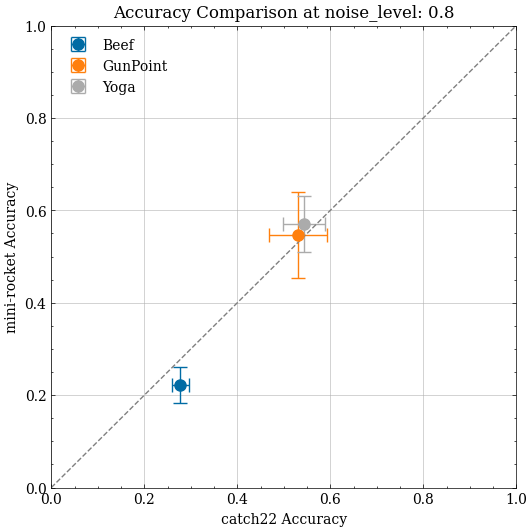

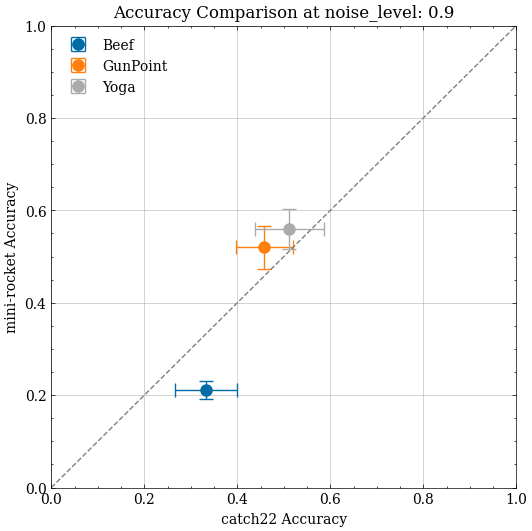

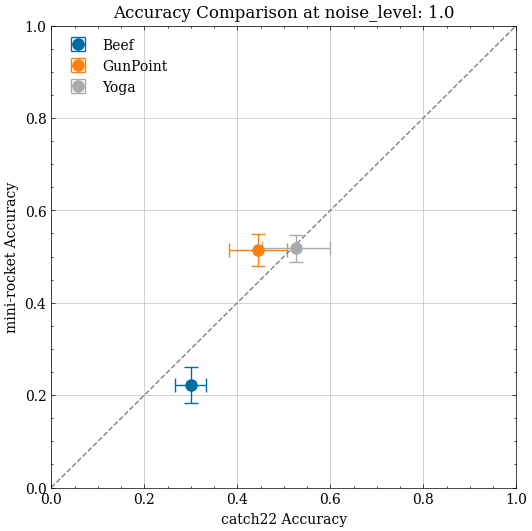

In [16]:
for classifier1, classifier2 in zip(
    subset_results["classifier"].unique()[:-1],
    subset_results["classifier"].unique()[1:],
):
    if classifier1 == classifier2:
        continue
    for strategy_params_value in sorted(
        subset_results[strategy_params_compare].unique()
    ):
        if strategy_params_value is None:
            continue

        fig = plot_accuracy_comparison(
            classifier1=classifier1,
            classifier2=classifier2,
            strategy_params_compare=strategy_params_compare,
            strategy_params_value=strategy_params_value,
            subset_results=subset_results,
            prepare_save_plot=True,
            **{name: True for name in dataset_names},
        )


        fig.savefig(
            os.path.join(strategy_figure_path, f"{classifier1}_{classifier2}_{strategy_params_value}.pdf"),
            dpi=300,
        )

In [17]:
def plot_accuracy_trajectory(
    classifier1,
    classifier2,
    subset_results,
    strategy_params_compare,
    prepare_save_plot: bool = False,
    **datasets_selected,
):
    fig, ax = plt.subplots(figsize=(6, 6))
    strategy_params_available = sorted(subset_results[strategy_params_compare].unique())

    for dataset in dataset_names:
        if not datasets_selected.get(dataset, True):
            continue
        ds = subset_results[
            (subset_results["dataset"] == dataset)
            & (
                subset_results["classifier"].isin(
                    [classifier1, classifier2]
                )
            )
        ]
        if ds.empty:
            continue

        x_means, y_means, x_stds, y_stds = [], [], [], []
        valid_strategy_params = []

        for fr in strategy_params_available:
            fr_ds = ds[ds[strategy_params_compare] == fr]
            grouped = (
                fr_ds.groupby(["random_seed", "classifier"])["accuracy"]
                .mean()
                .unstack()
            )
            if (
                grouped is None
                or classifier1 not in grouped
                or classifier2 not in grouped
            ):
                continue
            x = grouped[classifier1]
            y = grouped[classifier2]
            if len(x) == 0 or len(y) == 0:
                continue
            x_means.append(x.mean())
            y_means.append(y.mean())
            x_stds.append(x.std())
            y_stds.append(y.std())
            valid_strategy_params.append(fr)

        if valid_strategy_params:
            plt.errorbar(
                x_means,
                y_means,
                xerr=x_stds,
                yerr=y_stds,
                fmt="-o",
                label=dataset,
                capsize=3,
                markersize=5,
            )

    ax.set_xlabel(classifier1 + " Accuracy")
    ax.set_ylabel(classifier2 + " Accuracy")
    ax.set_title(
        f"Accuracy Trajectory Across {strategy_params_compare} (from {min(strategy_params_available)} to {max(strategy_params_available)})"
    )
    ax.axline((0, 0), slope=1, color="grey", linestyle="--")
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.legend()
    plt.show()

    if prepare_save_plot:
        return fig


_ = interact(
    plot_accuracy_trajectory,
    classifier1=Dropdown(
        options=subset_results["classifier"].unique(),
        description="Classifier 1",
    ),
    classifier2=Dropdown(
        options=subset_results["classifier"].unique(),
        description="Classifier 2",
    ),
    subset_results=fixed(subset_results),
    strategy_params_compare=fixed(strategy_params_compare),
    prepare_save_plot=fixed(False),
    **dataset_checkboxes,
)

interactive(children=(Dropdown(description='Classifier 1', options=('catch22', 'mini-rocket'), value='catch22'…

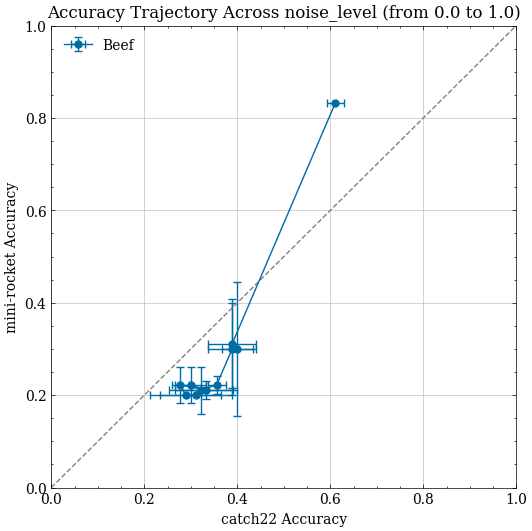

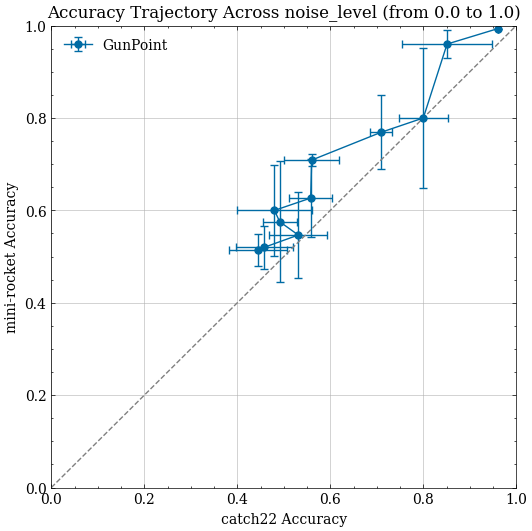

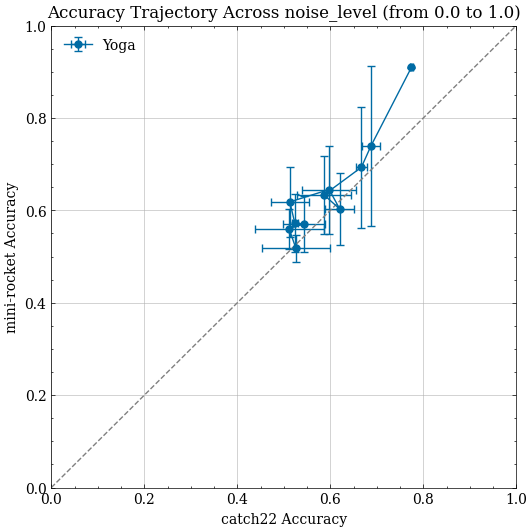

In [18]:
for classifier1, classifier2 in zip(
    subset_results["classifier"].unique()[:-1],
    subset_results["classifier"].unique()[1:],
):
    if classifier1 == classifier2:
        continue
    for data_set in subset_results["dataset"].unique():
        if data_set is None:
            continue

        fig = plot_accuracy_trajectory(
            classifier1=classifier1,
            classifier2=classifier2,
            subset_results=subset_results,
            strategy_params_compare=strategy_params_compare,
            prepare_save_plot=True,
            **{name: False if name != data_set else True for name in dataset_names},
        )

        fig.savefig(
            os.path.join(
                strategy_figure_path,
                f"trajectory_{classifier1}_{classifier2}_{data_set}.pdf"
            ),
            dpi=300,
        )